In [1]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms
from scipy.spatial import distance_matrix

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
toTensor = transforms.ToTensor()

sample_size = 80
xSub = x_train[:sample_size]
ySub = y_train[:sample_size]

xTensor = toTensor(xSub)
xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 1, 28, 28) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

In [4]:
negative_i_dict = {}

for label in set(ySub):
    negative_i_dict[label] = [i for i in range(len(ySub)) if ySub[i] != label ]

negative_i_dict

{0: [0,
  1,
  2,
  4,
  5,
  6,
  7,
  8,
  9,
  11,
  12,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  26,
  27,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  70,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79],
 1: [0,
  1,
  3,
  4,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  30,
  32,
  33,
  34,
  35,
  36,
  38,
  41,
  42,
  43,
  44,
  45,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  75,
  76,
  77,
  78,
  79],
 2: [0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
 

In [5]:
margin = 32

model = nn.Sequential(  nn.Flatten(),
                        nn.Linear(28*28,512),
                        nn.ReLU(),
                        nn.Linear(512,256),
                        nn.ReLU(),
                        nn.Linear(256,32),
                        nn.Sigmoid()
                        )

optimizer = optim.SGD( model.parameters() )
criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                 margin=margin
                                 )

In [6]:
def getAPN(a, pos, dMatrix):
    aP = [a]+pos
    neg_i = [i for i in range(len(dMatrix)) if i not in aP ]

    outPut = []

    for p in  pos:
        posDist = dMatrix[a][p]
        
        legal_i = [i for i in neg_i if posDist < dMatrix[a][i] <= posDist+margin] # i = "global" index of the Hash
        
        legal_dist = [dMatrix[a][i] for i in legal_i]
        
        if legal_dist == []: continue
        max_dist = min(legal_dist)

        n = legal_i[ legal_dist.index(max_dist) ]
        outPut.append( (a, p, n) )

    return outPut

In [6]:


batchSize = 80
for qwe in range(5000):

    for i in list(range(0, len(xSub) , batchSize)):
        start = i
        end = i + batchSize

        xBatch = xTensor[start:end]
        yBatch = ySub[start:end]

        results = model(xBatch)
        results_np = results.detach().numpy()

        dMatrix = distance_matrix(results_np, results_np, p=1)

        APN_list = []

        for label in set(yBatch):
            pos_i_list = [j for j in range(len(yBatch)) if yBatch[j] == label]

            for anchor_i in pos_i_list:
                pos_i = [j for j in pos_i_list if j != anchor_i]

                APN_list += getAPN(anchor_i, pos_i, dMatrix)


        a_list = []
        p_list = []
        n_list = []

        for apn in APN_list:
            a_list.append(results[ apn[0] ])
            p_list.append(results[ apn[1] ])
            n_list.append(results[ apn[2] ])
        
        # === Improve Model ===
        optimizer.zero_grad()

        loss = criterion(torch.stack(a_list),
                        torch.stack(p_list),
                        torch.stack(n_list) )
        
        loss.backward()
        optimizer.step()

        print(qwe ,i, loss)

0 0 tensor(31.9980, grad_fn=<MeanBackward0>)
1 0 tensor(31.9980, grad_fn=<MeanBackward0>)
2 0 tensor(31.9979, grad_fn=<MeanBackward0>)
3 0 tensor(31.9979, grad_fn=<MeanBackward0>)
4 0 tensor(31.9979, grad_fn=<MeanBackward0>)
5 0 tensor(31.9979, grad_fn=<MeanBackward0>)
6 0 tensor(31.9979, grad_fn=<MeanBackward0>)
7 0 tensor(31.9978, grad_fn=<MeanBackward0>)
8 0 tensor(31.9978, grad_fn=<MeanBackward0>)
9 0 tensor(31.9978, grad_fn=<MeanBackward0>)
10 0 tensor(31.9977, grad_fn=<MeanBackward0>)
11 0 tensor(31.9977, grad_fn=<MeanBackward0>)
12 0 tensor(31.9977, grad_fn=<MeanBackward0>)
13 0 tensor(31.9977, grad_fn=<MeanBackward0>)
14 0 tensor(31.9977, grad_fn=<MeanBackward0>)
15 0 tensor(31.9977, grad_fn=<MeanBackward0>)
16 0 tensor(31.9977, grad_fn=<MeanBackward0>)
17 0 tensor(31.9977, grad_fn=<MeanBackward0>)
18 0 tensor(31.9977, grad_fn=<MeanBackward0>)
19 0 tensor(31.9977, grad_fn=<MeanBackward0>)
20 0 tensor(31.9977, grad_fn=<MeanBackward0>)
21 0 tensor(31.9977, grad_fn=<MeanBackward0>

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

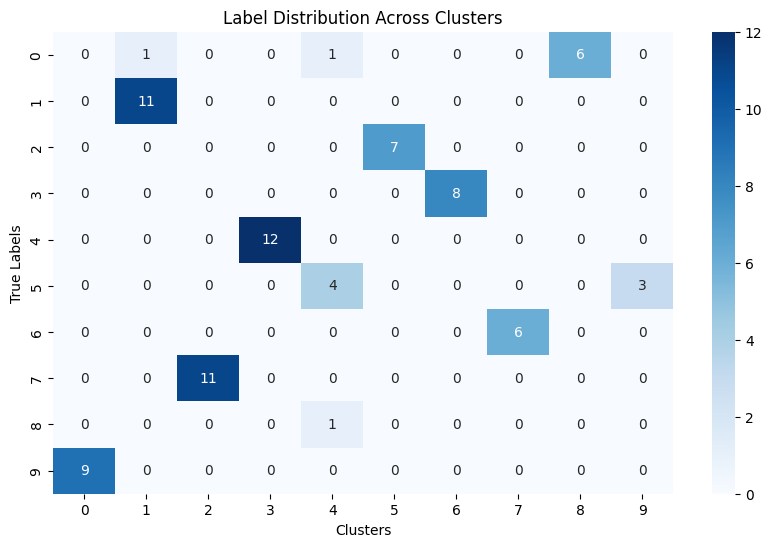

In [10]:
easyHeatmap(model(xTensor).detach().numpy(), ySub)

In [15]:
toTensor = transforms.ToTensor()

sample_size = 5000
xSub = x_train[:sample_size]
ySub = y_test[:sample_size]

xTensor = toTensor(xSub)
xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 1, 28, 28) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

xBatch = xTensor

results = model(xBatch)
results_np = results.detach().numpy()

dMatrix = distance_matrix(results_np, results_np, p=1)


In [16]:
len(xTensor)

5000